# FRAUD DETECTION PROJECT
## Project Purpose and Motivation

The primary purpose of this project is to address the critical industry problem of financial fraud by developing an accessible, real-time prediction tool. Fraudulent transactions—especially money transfers and cash-outs—pose a significant risk to financial institutions, resulting in substantial monetary losses and erosion of customer trust.

### The motivation for building this application was twofold:

1. To demonstrate expertise in machine learning model development (classification), and model deployment (Streamlit).

2. To create a practical, user-friendly interface that allows financial analysts or risk managers to instantly assess the probability of a new transaction being fraudulent based on key input features.

NOTE: For better understanding, I used Markdown.

### Import Neccessary Libraries  relevant to this project

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib

In [54]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### Load Dataset 

In [55]:
data= pd.read_csv("Fraud Dataset.csv")

### By default .head() returns first 5 Rows

In [56]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### By default .tail() returns last 5 Rows

In [110]:
data.tail()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,BalanceDiffOrig,balanceDiffDest
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,339682.13,339682.13
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,6311409.28,0.00
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,6311409.28,6311409.27
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,850002.52,0.00
6362619,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0,850002.52,850002.52


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [58]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### Exploratory Data Analysis (EDA)

In [59]:
data["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [60]:
data["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [61]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [62]:
data.shape

(6362620, 11)

In [63]:
round((data["isFraud"].value_counts()[1]/ data.shape[0])*100,2)

0.13

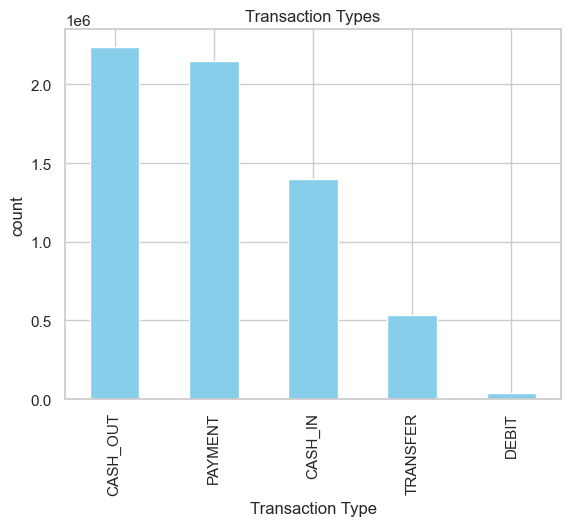

In [64]:
data["type"].value_counts().plot(kind= "bar",title= "Transaction Types",color= "skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("count")
plt.show()

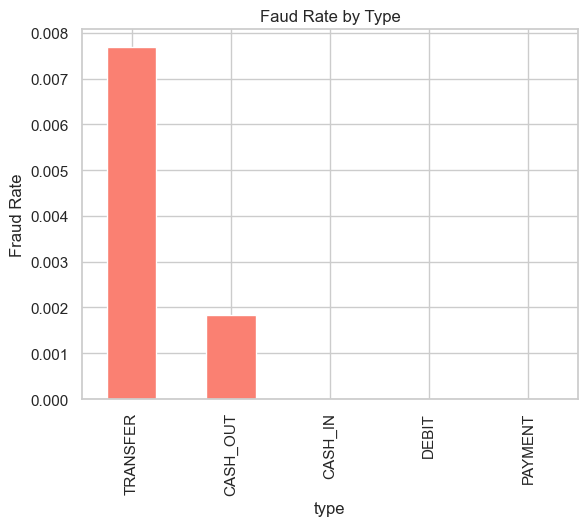

In [65]:
fraud_by_type = data.groupby("type")["isFraud"].mean().sort_values(ascending= False)
fraud_by_type.plot(kind= "bar",title= "Faud Rate by Type", color= "salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [66]:
data["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

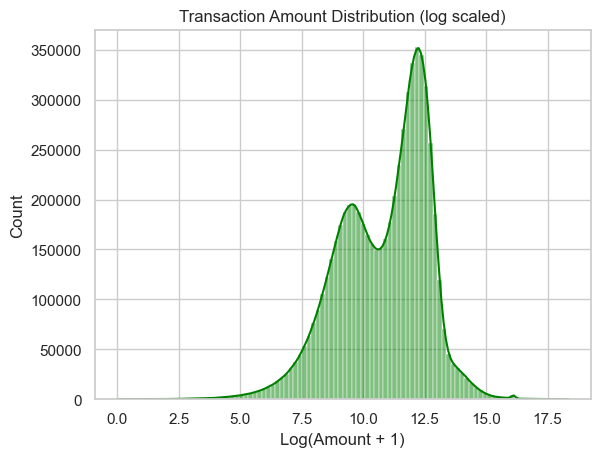

In [67]:
sns.histplot(np.log1p(data["amount"]),bins=100,kde= True,color="green")
plt.title("Transaction Amount Distribution (log scaled)")
plt.xlabel("Log(Amount + 1)")
plt.show()

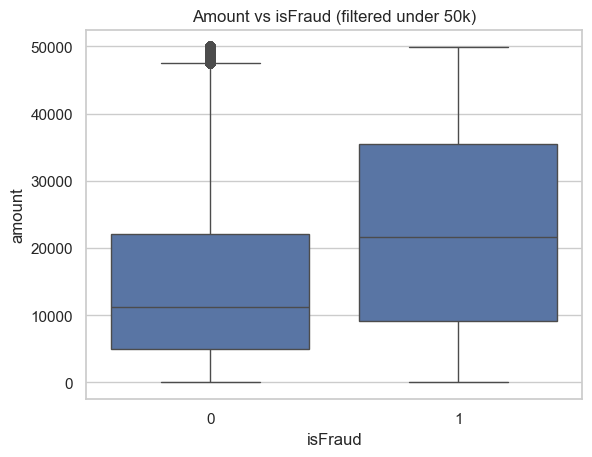

In [68]:
sns.boxplot(data=data[data["amount"]<50000],x= "isFraud",y= "amount")
plt.title("Amount vs isFraud (filtered under 50k)")
plt.show()

In [69]:
data["BalanceDiffOrig"]= data["oldbalanceOrg"]- data["newbalanceOrig"]
data["balanceDiffDest"]=data["newbalanceDest"]- data["oldbalanceDest"]

In [70]:
(data["BalanceDiffOrig"] < 0).sum()

1399253

In [71]:
(data["balanceDiffDest"] < 0).sum()

1238864

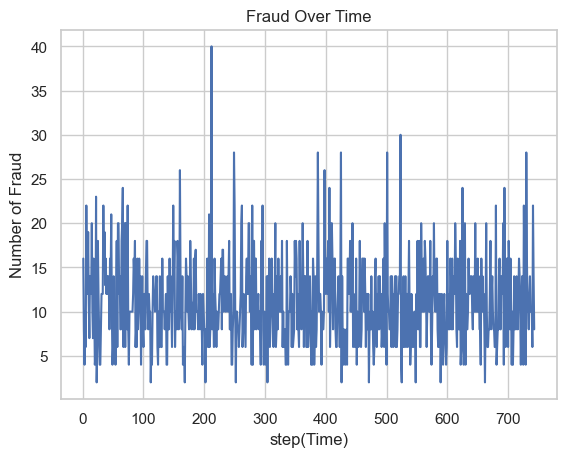

In [72]:
Fraud_per_step= data[data["isFraud"]== 1]["step"].value_counts().sort_index()
plt.plot(Fraud_per_step.index, Fraud_per_step.values, label= "Frauds per step")
plt.xlabel("step(Time)")
plt.ylabel("Number of Fraud")
plt.title("Fraud Over Time")
plt.grid(True)
plt.show()

In [73]:
data.drop(columns= "step", inplace= True)

In [74]:
data.head(2)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,BalanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


#### Top 10 Sender

In [75]:
top_sender = data["nameOrig"].value_counts().head(10)


In [76]:
top_sender

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

#### Top 10 Reciever

In [77]:
top_reciever = data["nameDest"].value_counts().head(10)

In [78]:
top_reciever

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

#### Top 10 Fraud Users

In [79]:
fraud_users = data[data["isFraud"]==1]["nameOrig"].value_counts().head(10)

In [80]:
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

### Fraud Type

In [81]:
fraud_types= data[data['type'].isin(["TRANSFER","CASH_OUT"])]

In [82]:
fraud_types["type"].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

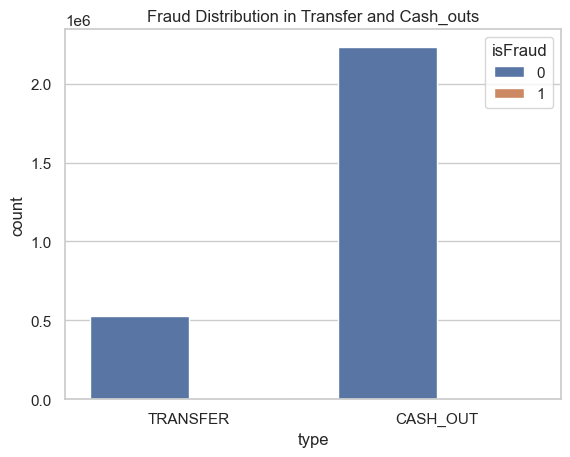

In [83]:
sns.countplot(data= fraud_types,x="type", hue= "isFraud")
plt.title("Fraud Distribution in Transfer and Cash_outs")
plt.show()

### Correlation

In [84]:
corr = data[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]].corr()

In [85]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


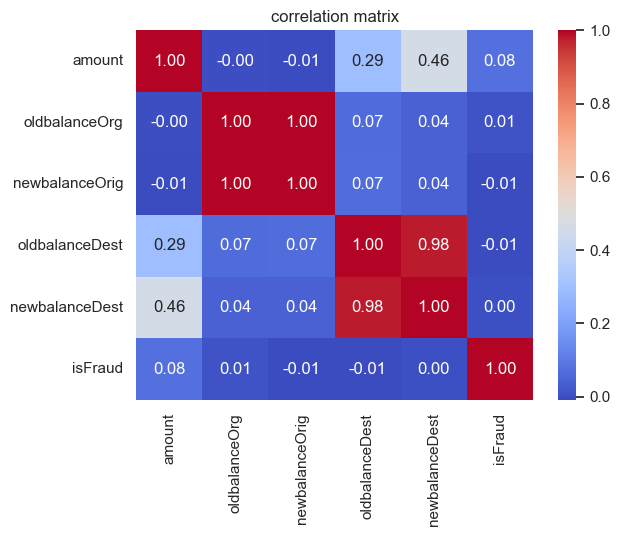

In [86]:
sns.heatmap(corr,annot=True,cmap= "coolwarm",fmt= ".2f")
plt.title("correlation matrix")
plt.show()

In [87]:
zero_after_transfer= data[
(data["oldbalanceOrg"]> 0)  &
(data["newbalanceOrig"]== 0) &
(data["type"].isin(["TRANSFER","CASH_OUT"]))
]

In [88]:
len(zero_after_transfer)

1188074

In [89]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,BalanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [90]:
data.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,BalanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


#### Dropped columns i didnt need for my model

In [91]:
data_model= data.drop(["nameOrig","nameDest","isFlaggedFraud"], axis= 1)

In [92]:
data_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,BalanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [93]:
categorical = ["type"]
Numeric = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

### Split data for model

In [94]:
y= data_model["isFraud"]
X= data_model.drop("isFraud", axis = 1)

In [95]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, stratify= y)

In [96]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4453834, 8), (1908786, 8), (4453834,), (1908786,))

In [97]:
preprocessor = ColumnTransformer(
    transformers=[
    ("num", StandardScaler(),Numeric),
    ("cat",OneHotEncoder(drop="first"), categorical)
    ],
    remainder= "drop"
)

In [98]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])


#### Train model

In [99]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

#### Prediction

In [100]:
y_pred= pipeline.predict(X_test)

In [102]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.93      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [103]:
confusion_matrix(y_test,y_pred)

array([[1804182,  102140],
       [    170,    2294]], dtype=int64)

In [107]:
pipeline.score(X_test,y_test) * 100

94.6400487011116

## Save the Model

In [109]:
joblib.dump(pipeline,"Fraud_detection.pkl")

['Fraud_detection.pkl']